In [1]:
'''
creating a Regression model to predict the fuel efficiency of the late-1970s and early 1980s 
automobiles. 
(building the model, validating using kfold validation, 
generating predictions using the test data)
'''

import numpy as np
import pandas as pd

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [2]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [3]:
dataset = dataset.dropna()

In [4]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [5]:
#features =data-labels
features = dataset.drop(['MPG'], axis = 1)
features = np.array(features)
target = dataset['MPG']

In [6]:
from sklearn import preprocessing, model_selection
train_data, test_data, train_targets, test_targets = model_selection.train_test_split(features,target,test_size=0.3)

In [7]:
train_data.shape

(274, 7)

In [8]:
test_data.shape

(118, 7)

In [9]:
train_targets

164    21.0
302    34.5
205    28.0
146    28.0
70     13.0
       ... 
239    30.0
229    16.0
180    25.0
378    38.0
338    27.2
Name: MPG, Length: 274, dtype: float64

In [10]:
'''Normalizing the data'''

#z normalization: (data - mean)/std
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [11]:
'''Model definition'''
from tensorflow.keras import layers
from tensorflow import keras

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="linear")
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

In [12]:
from sklearn.model_selection import KFold

k = 4
num_epochs = 100
all_scores = []

kf = KFold(n_splits=k, shuffle=True, random_state = 15)
for train_index, val_index in kf.split(train_data):
    print(f"Processing fold #{len(all_scores)}")

    #using KFold indices to partition the data
    partial_train_data, val_data = train_data[train_index], train_data[val_index]
    partial_train_targets, val_targets = train_targets.iloc[train_index], train_targets.iloc[val_index]

    #building the Keras model (already compiled)
    model = build_model()

    #training the model (in silent mode, verbose = 0)
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=16, verbose=0)

    #evaluating the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [13]:
all_scores

[2.5596749782562256, 2.2712717056274414, 2.085554361343384, 2.204989194869995]

In [14]:
np.mean(all_scores)

2.2803725600242615

In [17]:
k = 4
num_epochs = 500
all_mae_histories = []

kf = KFold(n_splits=k, shuffle=True, random_state = 15)
for fold_num, (train_index, val_index) in enumerate(kf.split(train_data), start=1):
    print(f"Processing fold #{fold_num - 1}")

    #using KFold indices to partition the data
    partial_train_data, val_data = train_data[train_index], train_data[val_index]
    partial_train_targets, val_targets = train_targets.iloc[train_index], train_targets.iloc[val_index]
    
    #building the Keras model (already compiled)
    model = build_model()

    #training the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    
#     #check if the history object contains data
#     print("History for this fold:", history.history)

    mae_history = history.history.get("val_mae", [])
    all_mae_histories.append(mae_history)

#checking the length of all_mae_histories
print(len(all_mae_histories))


Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
4


In [21]:
'''building the history of successive mean K-fold validation scores'''

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

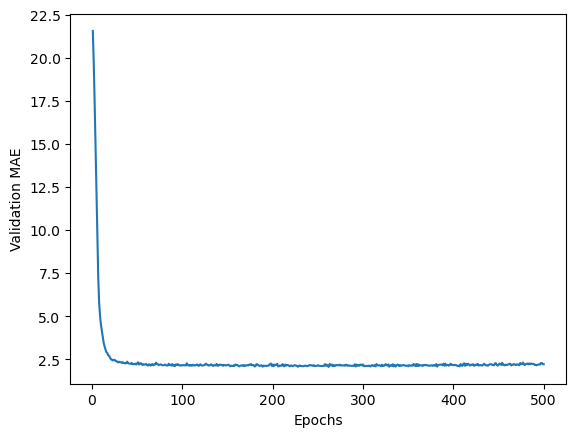

In [22]:
'''plotting validation scores'''

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

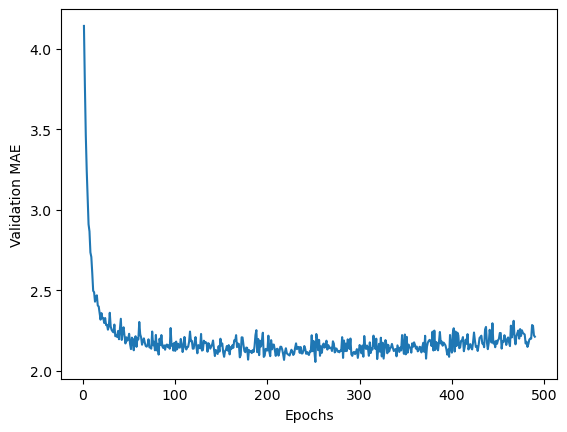

In [23]:
'''plotting validation scores, excluding the first 10 data points'''
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [24]:
'''training the final model'''
#MAE stops improving after about 290 epochs 

#Gets a fresh, compiled model
model = build_model()
model.fit(train_data, train_targets,
#Trains it on the entirety of the data
          epochs=290, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 685us/step - loss: 5.4595 - mae: 1.6872


In [25]:
test_mae_score

1.6872292757034302

In [26]:
predictions = model.predict(test_data)
predictions[0]

4/4 [==============================] - 0s 613us/step


array([26.814253], dtype=float32)

In [27]:
test_targets.iloc[0]

20.0